In [1]:
using Revise
includet("../scripts/minimal_semisymb.jl")
using CairoMakie


Welcome to Nemo version 0.48.4

Nemo comes with absolutely no warranty whatsoever


In [2]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

In [12]:
################################################################################

In [273]:
mmpf = MinimalModelParamsSpace(0.1, 1., 2., 2., 2., 1e-5, 500., 0.1);
mmicrm_params = mmp_to_mmicrm(mmpf);

In [278]:
do_single_simple(mmpf)

(1, [[1.707713444882653, 13.201803603144423]], [[0, 1, 0]], 1)

In [220]:
typeof(M1)

Matrix{Float64} (alias for Array{Float64, 2})

In [221]:
typeof(make_M(M1, 0., get_Ds(mmpf)))

SizedMatrix{3, 3, Float64, 2, Matrix{Float64}} (alias for SizedArray{Tuple{3, 3}, Float64, 2, 2, Array{Float64, 2}})

In [223]:
MM = make_M(M1, 1., get_Ds(mmpf))

3×3 SizedMatrix{3, 3, Float64, 2, Matrix{Float64}} with indices SOneTo(3)×SOneTo(3):
 -1.0e-5        0.0      37.9737
 -0.102633   -538.974     0.0
  0.0026334    37.9737  -39.0737

In [252]:
find_nondec_modes(make_M(M1, 5, get_Ds(mmpf)))

(ComplexF64[0.0018764825783742054 + 0.0im], Vector{ComplexF64}[[-0.9999999983985646 + 0.0im, 8.185150643862e-6 + 0.0im, -5.599887503637396e-5 + 0.0im]])

In [254]:
find_number_nondec_modes(make_M(M1, 5, get_Ds(mmpf)))

1

In [83]:
e = eigen(M1 + 4 * I(3); sortby=eigen_sortby_reverse)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
   3.9046595049182073
 -32.974342247719704
 -36.877649179219055
vectors:
3×3 Matrix{Float64}:
 -0.999993    -0.715987   -0.680146
  0.00263984   0.0367545  -0.036663
  0.00251068   0.697145    0.732159

In [93]:
lal = findfirst(x->real(x)<-0.00001, e.values) - 1

1

In [98]:
lambdas = []
modes = []
for i in 1:lal
    push!(lambdas, e.values[i])
    push!(modes, e.vectors[:, i])
end
lambdas, modes

(Any[3.9046595049182073], Any[[-0.9999933638230213, 0.002639844221055347, 0.0025106836533318254]])

In [94]:
e.values[1:lal]

1-element Vector{Float64}:
 3.9046595049182073

# Numerics for comparison

In [7]:
u0 = make_mmicrmu0_smart(mmicrm_params; u0=:onlyN)
p = ODEProblem(mmicrmfunc!, u0, (0., 10000.), mmicrm_params)
s = solve(p)
# display(plot_mmicrm_sol(s))
usol = s.u[end]
display(usol)
@show maximum(uninplace(mmicrmfunc!)(usol, p.p, 0));

3-element Vector{Float64}:
 18.986832980485907
  0.051316701949536976
  0.05000000000004829

maximum((uninplace(mmicrmfunc!))(usol, p.p, 0)) = 1.8336633699101077e-12


maximum(real(lambdas)) = 0.0018830709764939603


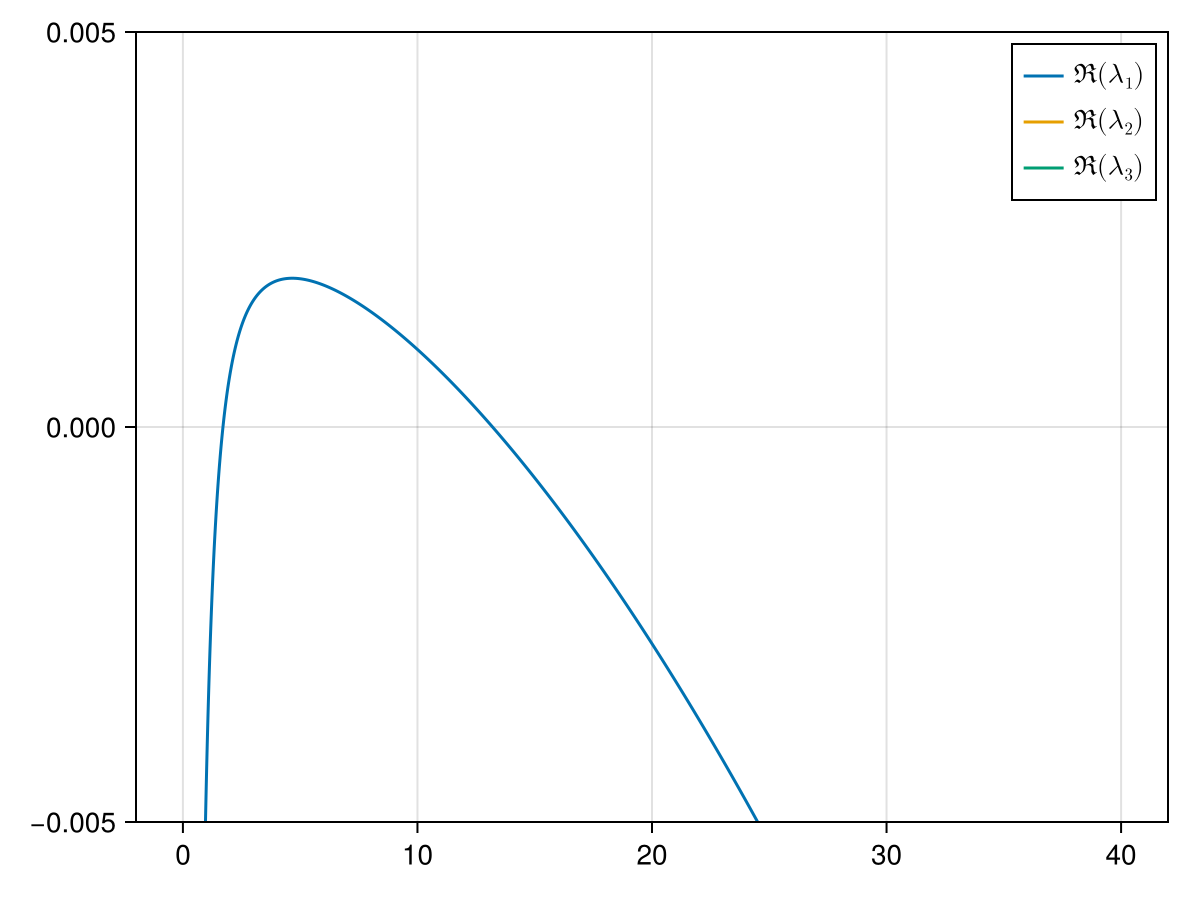

In [250]:
ks = LinRange(0., 40., 10000)
Ds = [mmpf.DN, mmpf.DG, mmpf.DR]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.005, 0.005))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [251]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.999999998425749
  9.40073015931161e-6
 -5.53184263874303e-5

# Bits and bobs

### Testing

In [19]:
xx = solve_nospace(mmpf)

3-element Vector{Vector{Float64}}:
 [18.986832980505135, 0.05131670194948621, 0.05000000000000001]
 [0.013167019494861876, 1.9486832980505142, 0.04999999999999954]
 [0.0, 2.0, 0.0]

In [21]:
M1 = make_M1(mmicrm_params, xx[1])

3×3 Matrix{Float64}:
  1.38778e-17    0.0      37.9737
 -0.102633     -38.9737    0.0
  0.0026334     37.9737  -38.9737

In [33]:
pol = make_K_polynomial(M1, get_Ds(mmpf))

4-element SVector{4, Float64} with indices SOneTo(4):
   -0.0005
   -0.19490730347101168
   49.98481053361589
 -144.099930651839

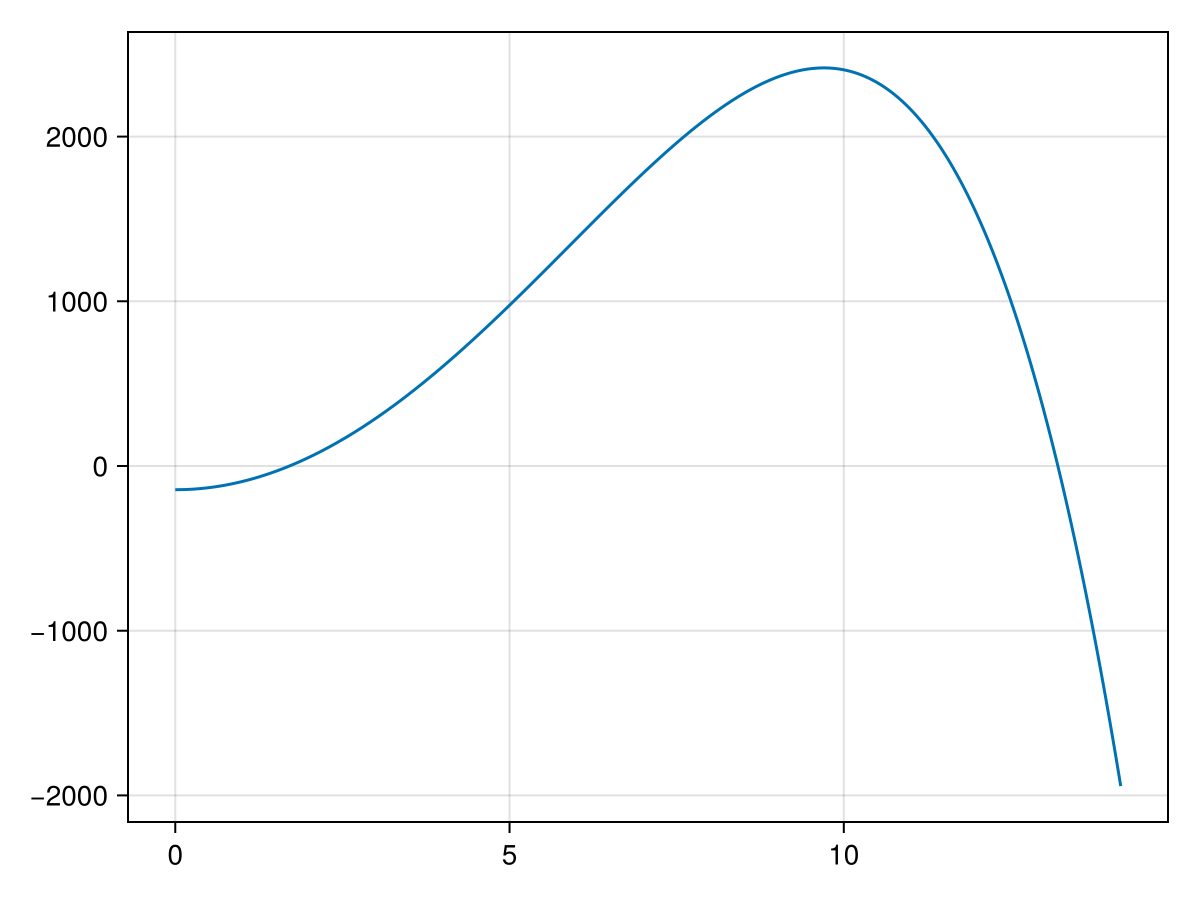

In [64]:
fks = LinRange(0, 200, 10000)
yy = eval_cubic.(Ref(pol), fks)
lines(sqrt.(fks), yy)

### Finding params so that D=0

In [45]:
@variables a b c d x p q t;
sx = t - 3*b / a
st = x + 3*b / a
display(sx)
display(st)

t + (-3b) / a

x + (3b) / a

In [47]:
ep = (3*a*c - b^2) / (3*a^2)
eq = (2*b^3 - 9*a*b*c + 27*a^2*d) / (27*a^3)
display(ep)
display(eq)

(3a*c - (b^2)) / (3(a^2))

(27(a^2)*d - 9a*b*c + 2(b^3)) / (27(a^3))

In [48]:
eD = q^2/4 + p^3/27
display(eD)

(1//4)*(q^2) + (1//27)*(p^3)

In [52]:
fD = simplify(substitute(substitute(eD, p=>ep), q=>eq))

((27//1)*(a^2)*(d^2) - (18//1)*a*b*c*d + (4//1)*a*(c^3) + (4//1)*(b^3)*d - (b^2)*(c^2)) / (108(a^4))

In [63]:
D0_sd = simplify(symbolic_solve(fD~0, d))

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 (√(-432(a^3)*(c^3) + 432(a^2)*(b^2)*(c^2) - 144a*(b^4)*c + 16(b^6)) + 18a*b*c - 4(b^3)) / (54(a^2))
 (-√(-432(a^3)*(c^3) + 432(a^2)*(b^2)*(c^2) - 144a*(b^4)*c + 16(b^6)) + 18a*b*c - 4(b^3)) / (54(a^2))

In [77]:
simplify(substitute(D0_sd[1], [a=>1,b=>1,c=>0.1]))

0.002641631005470585571790650969636567983439420046482461039933878046183213123669783